<a href="https://colab.research.google.com/github/junsookim76/Ewha_2023/blob/main/11_MP_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=crimson>Table of Contents</font>

* __Initial Setting__
>
> 라이브러리 설치하기
>
* __Playing with RDKIT__
>
> 분자 다루기
>
* __Reading Database__
>
* __Data Analysis__
>
> 데이터 살펴보기
>
* __Descriptor 계산__
>
* __Data Analysis__
>
> 데이터 상관관계 확인하기
>
* __Multi Linear Regression (머신러닝 실행)__
>
> 머신러닝 실행
>
> 예측 결과 확인


# <font color=crimson>Initial Setting</font>

* __라이브러리 설치하기__
>
>1. Ochem (Online Chemical Database): SMILES + MP + INCHI_KEY
>2. Chembl: SMILES + Chembl ID 


In [3]:
#!pip install mordred seaborn
!pip install mordred rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 14.7 MB/s eta 0:00:00


In [4]:
from mordred import Calculator, descriptors

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

IPythonConsole.ipython_useSVG=True

# <font color=crimson>Playing with RDKIT</font>

* __분자 다루기__
>


In [5]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

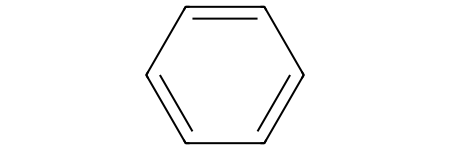

In [6]:
mol=Chem.MolFromSmiles("c1ccccc1")
mol

In [7]:
for atom in mol.GetAtoms():
    print(atom.GetIdx())

0
1
2
3
4
5


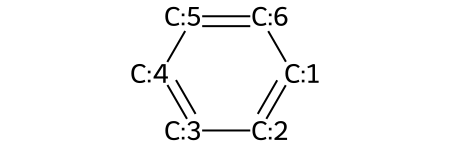

In [8]:
# With atom index
mol_with_atom_index(mol)

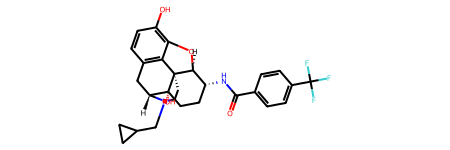

In [9]:
mol=Chem.MolFromSmiles("C1C[C@]2([C@H]3CC4=C5[C@@]2(CCN3CC6CC6)[C@H]([C@@H]1NC(=O)C7=CC=C(C=C7)C(F)(F)F)OC5=C(C=C4)O)O")
mol

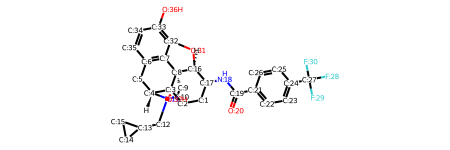

In [10]:
# With atom index
mol_with_atom_index(mol)

# <font color=crimson>Reading Database</font>

* __Source__
>
>1. Ochem (Online Chemical Database): SMILES + MP + INCHI_KEY
>2. Chembl: SMILES + Chembl ID 


In [12]:

!git clone https://github.com/junsookim76/Data.git
csv_file_name = "./Data/melting_point_ochem_smi.csv"

sample_data = pd.read_csv(csv_file_name)
smi = sample_data.iloc[:,0]
mp = sample_data.iloc[:,1]

mp = pd.to_numeric(mp, errors='coerce')
smi_mp = pd.concat([smi,mp], axis=1)

mpn = smi_mp.dropna()

print(mpn.head(10))

mpn.to_csv('mpn.csv')
                    
mols=[]

for _,i in mpn.iterrows():
    mol=Chem.MolFromSmiles(i["SMILES"])
    mols.append(mol)


Cloning into 'Data'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), 696.45 KiB | 3.33 MiB/s, done.
                                              SMILES  Melting Point
0  CN(C1=CC2=NC3=C(C=CC4=C3COCN4)C=C2C=C1)S(C)(=O)=O          300.0
1    CNC1=CC=C2C=C3C=CC(=CC3=NC2=C1CO)N(C)S(C)(=O)=O          150.0
2  CCOC(=O)NC1=CC2=NC3=C(C=CC4=C3COCN4C(=O)OCC)C=...          174.0
3   CCOC(=O)NC1=CC=C2C=C3C=CC4=C(COC(=O)N4)C3=NC2=C1          235.0
4        CCOC(=O)NC1=CC2=NC3=C(C=CC(N)=C3CO)C=C2C=C1          135.0
5       CCOC(=O)NC1=CC2=NC3=C(C=CC(NC)=C3CO)C=C2C=C1          145.0
6          CN1COCC2=C1C=CC1=C2N=C2C(C=CC(N)=C2CO)=C1          235.0
7  CCOC(=O)N1COCC2=C1C=CC1=C2N=C2C(CO)=C(NC)C=CC2=C1          146.0
8  CCOC(=O)N1COCC2=C1C=CC1=CC3=C(N=C21)C1=C(C=C3)...          195.0
9        C1NC2=C(CO1)C1=NC3=C(C=CC4=C

In [ ]:
#mols=[]
#!git clone https://github.com/junsookim76/Data.git
#with open("./Data/chembl_mini.smi") as f:
#with open("/storage/cbpc/chembl_mini.smi") as f:
#    for line in f.readlines():
#        data=line.split()
#        mol=Chem.MolFromSmiles(data[0])
#        mol.SetProp("chembl_id",data[1])
#        mol.SetProp("smiles",data[0])
#        mols.append(mol)

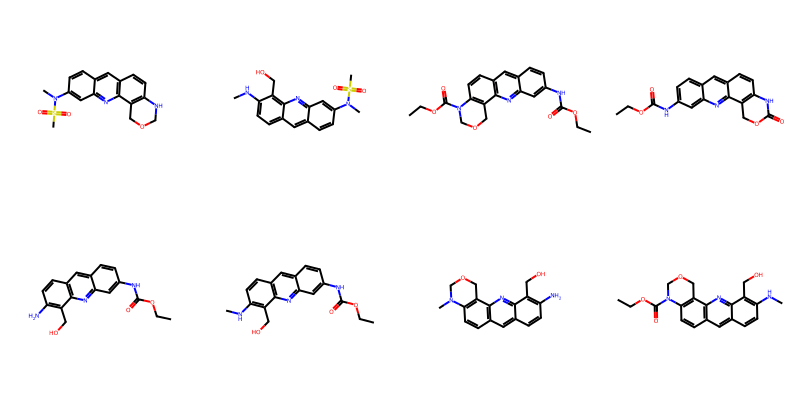

In [13]:
Draw.MolsToGridImage(mols[:8],molsPerRow=4)

# <font color=crimson>Data Analysis</font>
>## <font color=black>데이터 살펴보기</font>

In [14]:
mpn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14897 entries, 0 to 21882
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SMILES         14897 non-null  object 
 1   Melting Point  14897 non-null  float64
dtypes: float64(1), object(1)
memory usage: 349.1+ KB


In [15]:
print(mpn.iloc[:,1].head(10))

0    300.0
1    150.0
2    174.0
3    235.0
4    135.0
5    145.0
6    235.0
7    146.0
8    195.0
9    235.0
Name: Melting Point, dtype: float64


<ipython-input-16-c9d69db31db4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mpn['Melting Point'])


<Axes: xlabel='Melting Point', ylabel='Density'>

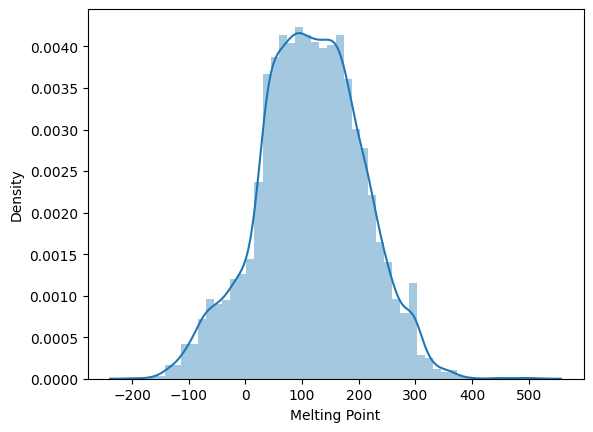

In [16]:
sns.distplot(mpn['Melting Point'])

# <font color=crimson>Descriptor 계산하기</font>

* __Mordred Descriptors__
>


# Mordred Descriptors

In [17]:
calc=Calculator(descriptors.ABCIndex)

In [18]:
calc.register(descriptors.AcidBase)
calc.register(descriptors.Aromatic)
calc.register(descriptors.AtomCount)
calc.register(descriptors.BondCount)
calc.register(descriptors.BalabanJ)
calc.register(descriptors.HydrogenBond)
calc.register(descriptors.Polarizability)
calc.register(descriptors.WalkCount)
calc.register(descriptors.Weight)
calc.register(descriptors.TopologicalCharge)
calc.register(descriptors.Constitutional)
#calc.register(descriptors.ZagrebIndex)
#calc.register(descriptors.AdjacencyMatrix)
#calc.register(descriptors.SLogP)
#calc.register(descriptors.WienerIndex)
#calc.register(descriptors.Autocorrelation)
#calc.register(descriptors.EState)
print(len(calc.descriptors))

97


In [19]:
mordred=calc.pandas(mols)
mordred.to_csv('./mordred_97.csv')


100%|██████████| 14897/14897 [02:10<00:00, 114.26it/s]


In [20]:
print(mordred.shape)

(14897, 97)


In [21]:
mordred

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,Sp,Si,MZ,Mm,Mv,Mse,Mpe,Mare,Mp,Mi
0,19.414219,14.458738,0,0,14,16,41,24,0,0,...,28.941007,45.950382,0.731707,0.697330,0.663680,1.014753,0.982975,0.995610,0.705878,1.120741
1,18.707112,14.984016,0,0,14,16,43,24,0,0,...,29.739561,48.365672,0.705426,0.668800,0.645412,1.011459,0.977383,0.990233,0.691618,1.124783
2,22.603556,16.412053,0,0,14,16,50,29,0,0,...,33.762068,56.279686,0.693333,0.658421,0.650742,1.019301,0.988784,1.003280,0.675241,1.125594
3,19.856009,14.269577,0,0,14,16,40,25,0,0,...,27.886165,44.824431,0.733333,0.702138,0.679920,1.024272,0.997843,1.012100,0.697154,1.120611
4,17.734689,13.782162,0,0,14,16,40,23,0,0,...,27.204480,45.030335,0.683333,0.648033,0.650596,1.013201,0.982255,0.996100,0.680112,1.125758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14892,7.399237,7.388977,0,0,0,0,29,11,0,0,...,17.667230,32.946993,0.494253,0.442850,0.537629,0.976593,0.926842,0.939310,0.609215,1.136103
14893,20.440406,18.308961,1,0,11,11,40,27,0,0,...,27.546293,45.981186,0.900000,0.875824,0.683779,1.072669,1.051569,1.067900,0.688657,1.149530
14894,15.205921,12.691501,0,0,6,6,37,21,0,0,...,25.884244,41.905471,0.828829,0.802472,0.654712,1.037430,1.002968,1.008216,0.699574,1.132580
14895,16.356175,12.977056,0,0,0,0,42,20,0,0,...,27.744578,46.986958,0.579365,0.535961,0.604517,0.986370,0.944725,0.956190,0.660585,1.118737


# <font color=crimson>Data Analysis</font>
>## <font color=black>데이터 상관관계 확인</font>
>


# Analysis of Descriptors

<ipython-input-22-51f566cac23e>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.triu(np.ones_like(correlation, dtype=np.bool))


<Axes: >

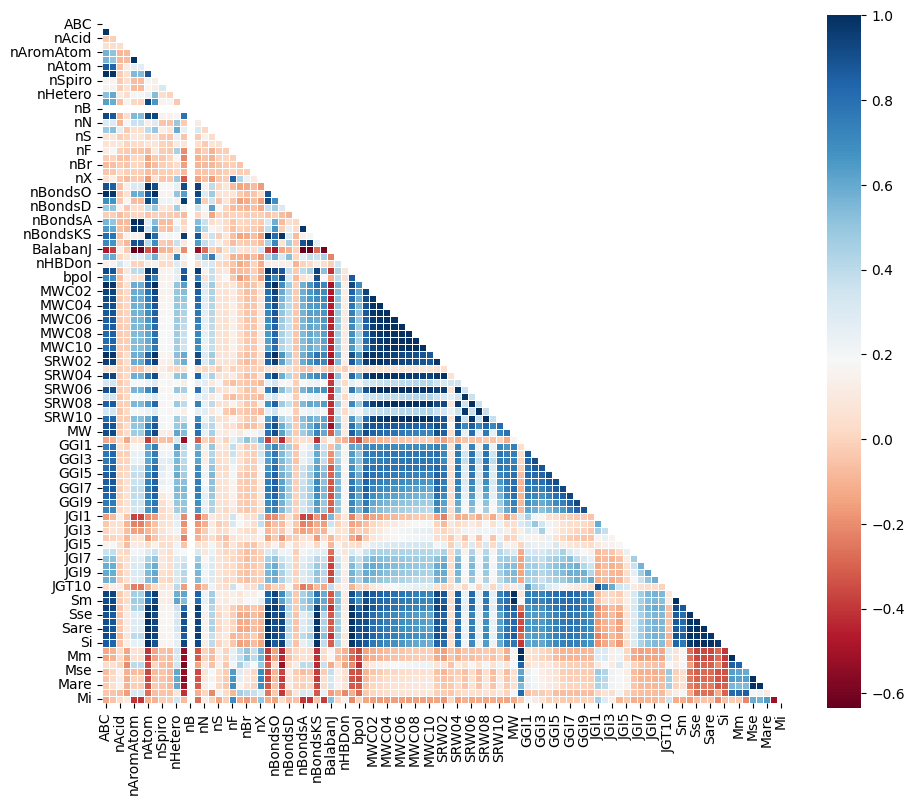

In [22]:
correlation=mordred.corr()
mask=np.triu(np.ones_like(correlation, dtype=np.bool))
f,ax=plt.subplots(figsize=(11, 9))
sns.heatmap(
    correlation,
    mask=mask,
    cmap="RdBu",
    square=True,
    linewidths=0.5,
)

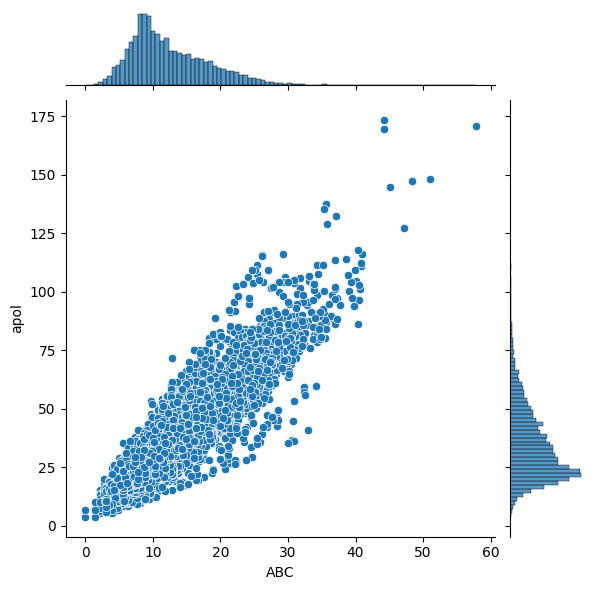

In [23]:
sns.jointplot(x='ABC',y='apol',data=mordred)

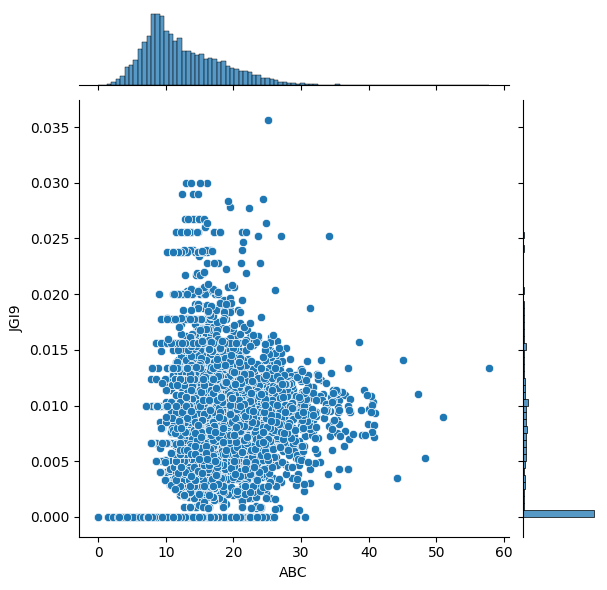

In [24]:
sns.jointplot(x='ABC',y='JGI9',data=mordred)

# <font color=crimson>Multi Linear Regression</font>
>## <font color=black>기계 학습 실행</font>
>


# Multi Linear Perceptron Regressor

In [25]:
MLR=make_pipeline(QuantileTransformer(),
                MLPRegressor(hidden_layer_sizes=(100, 50, 100),
                             learning_rate_init=0.01,
                             max_iter=500,
                             early_stopping=True))

# Training with Mordred Descriptors

In [26]:
X=mordred
y=mpn.iloc[:,1]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7)

In [28]:
MLR.fit(X_train, y_train)

Pipeline(steps=[('quantiletransformer', QuantileTransformer()),
                ('mlpregressor',
                 MLPRegressor(early_stopping=True,
                              hidden_layer_sizes=(100, 50, 100),
                              learning_rate_init=0.01, max_iter=500))])

# Prediction with a Test Set

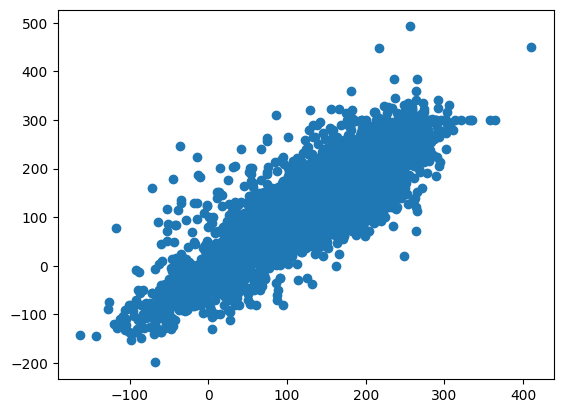

In [29]:
plt.plot(MLR.predict(X_test),y_test,"o")

MP: 42.000, P.MP: 69.516
MP: 261.000, P.MP: 189.424
MP: 151.500, P.MP: 106.150
MP: 40.000, P.MP: 62.787
MP: 55.000, P.MP: 41.256
MP: 271.000, P.MP: 270.540
MP: 217.000, P.MP: 195.370
MP: 62.000, P.MP: 91.772
MP: -78.000, P.MP: -77.538
MP: -70.000, P.MP: -30.169

RMSE(train) : 45.215250
RMSE : 48.733359
R^2 : 0.709108


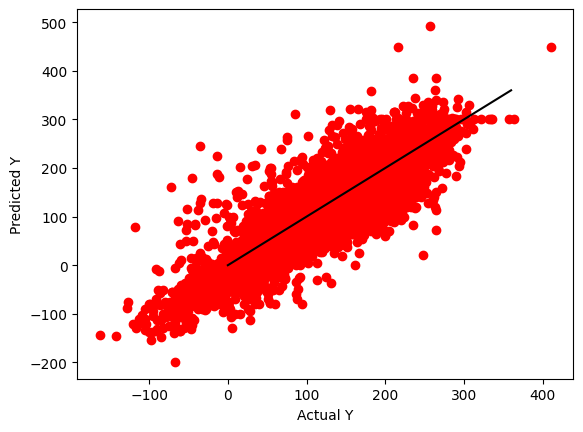

In [30]:
y_prediction = MLR.predict(X_test).flatten()
for i in range(10):
    label = y_test.iloc[i]
    prediction = y_prediction[i]
    print("MP: {:.3f}, P.MP: {:.3f}".format(label, prediction))
    
y_train_prediction = MLR.predict(X_train).flatten()
for i in range(90):
    label_train = y_train.iloc[i]
    prediction = y_train_prediction[i]

Squared = False
RMSE_train = mean_squared_error(y_train,y_train_prediction)**0.5
RMSE = mean_squared_error(y_test,y_prediction)**0.5

R2 = r2_score(y_test,y_prediction)

x0 = [0, 100, 360]
y0 = [0, 100, 360]

print ("\nRMSE(train) : %.6f" % RMSE_train)
print ("RMSE : %.6f" % RMSE)
print ("R^2 : %.6f" % R2)



plt.plot(y_prediction, y_test,  'ro')
#plt.plot(y_train, y_train_prediction, 'o', color='silver')
plt.plot(x0,y0, 'k-')
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.savefig('./DL.pdf')